# Data Mining

——文本分类：寻找24本书的相关性并将相似的聚类

## 1. 编写运算所需类和函数

In [53]:
%matplotlib inline
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import ward, dendrogram

from gensim import corpora, models, similarities

In [2]:
# filter stopwords
stopwords = stopwords.words('english')
en_words = set(words.words())
stemmer = SnowballStemmer('english')

In [3]:
# 按照文件读取顺序排列的书籍名称
book_id = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
titles = ['THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI',
          'THE HISTORIES CAIUS COBNELIUS TACITUS',
          'THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV',
          'THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL, I',
          'THE HISTORY OF TACITUS. BOOK I. VOL. V',
          'THE FIRST AND THIRTY-THIRD BOOKS OF PLINY\'S NATURAL HISTORY',
          'THE HISTORY OF THE ROMAN EMPIRE. VOL. V',
          'THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II',
          'THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II',
          'TITUS LIVIUS\' ROMAN',
          'THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL. I',
          'THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV',
          'DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II',
          'THE LEARNED AND AUTHENTIC JEWISH HISTORIAN AND CELEBRATED WARRIOR. VOL. III',
          'LIVY. VOL. III',
          'LIVY. VOL. V',
          'THE HISTORICAL ANNALS OF CORNELIUS TACITUS. VOL. I',
          'THE HISTORY OF THE PELOPONNESIAN WAR. VOL. I',
          'THE LEARNED AND AUTHENTIC JEWISH HISTORIAN,  AND CELEBRATED WARRIOR. VOL. IV',
          'THE DESCRIPTION OF GREECE',
          'THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. III',
          'TTHE HISTORY OF ROME. VOL. III',
          'HE HISTORY OF TACITUS. BOOK I. VOL. IV',
          'THE FLAVIUS JOSEPHU',
          ]

In [4]:
def tokenize_and_filter_punc(raw_text):
    tokens = nltk.wordpunct_tokenize(raw_text)
    text = nltk.Text(tokens)
    words = [w.lower() for w in text if w.isalpha()]   # 过滤掉特殊符号并将单词全部小写
    words = [w for w in words if len(w) >= 3]    # 去掉长度小于3的词

    return words

In [5]:
def tokenize_and_filter_stopwords(raw_text):
    tokens = wordpunct_tokenize(raw_text)
    text = nltk.Text(tokens)
    words = [w.lower() for w in text if w.isalpha()]
    words = [word for word in words if word not in stopwords]

    return words

In [6]:
class BookObject(object):
    """
    每一本书籍建立一个类的对象
    """
    def __init__(self, title, contents, raw_texts=''):
        self.__title = title
        self.__contents = contents
        self.__raw_texts = raw_texts

    @property
    def title(self):
        return self.__title

    @property
    def raw_texts(self):
        return self.__raw_texts

    @property
    def contents(self):
        return self.__contents.keys()

In [119]:
class TextClassification(object):
    """
    添加方法：
    添加一本书
    加载原始文本
    特征工程：计算文本单词数量，统计高频名词
    tf-idf方法
    doc2vec方法
    k-means方法
    hierachical方法
    mean-shift方法
    LDA方法
    """

    def __init__(self):
        self.__books = []
        self.__no_of_features = 0
        self.__total_vocabularies = []
        self.__tf_idf_matrix = None
        self.__d2v_model = None
        self.__d2v_vector = None

    @property
    def tf_idf_matrix(self):
        return self.__tf_idf_matrix

    @property
    def d2v_vector(self):
        return self.__d2v_vector

    def add_a_book(self, book):
        self.__books.append(book)

    # 特征工程
    # 打印单词数量
    def print_word_count(self):
        words_count = {}
        for book in self.__books:
            text_arr = book.raw_texts.strip().split()
            count = 0
            for w in text_arr:
                if len(w) > 0:
                    count += 1

            words_count[book.title] = count

        print('The word counts of each book is:\n')
        for key, value in words_count.items():
            print(key, ':', value)

    # 打印tokenize之后的单词数量
    def print_word_count_after_tokenization(self):
        words_count = {}
        for book in self.__books:
            text = book.raw_texts.strip()
            res = tokenize_and_filter_punc(text)
            words_count[book.title] = len(res)

        print('The word counts of each book after tokenize is:\n')
        for key, value in words_count.items():
            print(key, ':', value)

    # 输出每本书使用频率前20名的单词
    def highfreq_noun(self):
        print('High frequency noun in each book:\n')
        for book in self.__books:
            text = book.raw_texts
            tokens = tokenize_and_filter_punc(text)
            freq_dist = FreqDist(tokens)
            tagged = nltk.pos_tag(tokens)
            minfo = dict(freq_dist)
            info = list(set([k.lower() for k, v in tagged if v == 'NN']))
            kinfo = [(k, minfo.get(k)) for k in info]
            kinfo.sort(key=lambda k: k[1], reverse=True)
            kinfo = [w for w in kinfo if len(w[0]) > 3]
            output1 = ",".join([m[0] for m in kinfo[:20]])
            print('《', book.title[:-4], '》:\n', output1)
            output2 = " ".join([m[0] for m in kinfo[:20]])
            this_wordcloud = WordCloud().generate(output2)
            plt.imshow(this_wordcloud)
            plt.axis('off')
            plt.show()

    # 计算dist_matrix
    def dist_matrix(self, vector):
        dist_matrix = 1 - cosine_similarity(vector)

        return dist_matrix

        # TF-IDF计算词频

    def tf_idf(self):
        tfidf_matrix = None
        print('Training TF-IDF model...')
        tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=100000, min_df=0.01, stop_words='english',
                                           use_idf=True, tokenizer=tokenize_and_filter_punc, ngram_range=(1, 1))
        books = []
        for book in self.__books:
            books.append(book.raw_texts)

        tfidf_matrix = tfidf_vectorizer.fit_transform(books)

        self.__tf_idf_matrix = tfidf_matrix

        print('TF-IDF Done...')

    # Doc2vec
    def doc2vec(self, output_size=300, epoch=100):
        books = []
        for book in self.__books:
            books.append(book.raw_texts)

        tagged_docs = []
        # prepare doc2vec input - list of taggedDocument
        print('Start Tagging...')
        for index, text in enumerate(books):
            docTokens = tokenize_and_filter_stopwords(text)
#             print("tagging:" + str(index))
            tagged_docs.append(models.doc2vec.TaggedDocument(docTokens, [str(index) + "_" + titles[index]]))
        print('Tagging Done')
        
        # setup configurations
        d2vm = models.Doc2Vec(vector_size=output_size, min_count=0, alpha=0.025, min_alpha=0.025)
        d2vm.build_vocab(tagged_docs)

        print("Training doc2vec model..")
        # Train the doc2vec model
        for epoch in range(epoch):  # number of epoch
#             print("training ep:" + str(epoch))
            d2vm.train(tagged_docs, total_examples=len(tagged_docs), epochs=1)
            # Change learning rate for next epoch (start with large num to speed up at first and then decrease to fine grain learning)
            d2vm.alpha -= 0.002
            d2vm.min_alpha = d2vm.alpha
        # d2vm.train(tagged_docs, total_examples=len(tagged_docs), epochs=epoch )
        print("Done training..")
        ##d2vm.save('doc2vec.model')
        self.__d2v_model = d2vm

    # 转换为向量
    def doc2vec_to_vectors(self):
        # Extract vectors from doc2vec model
        feature_vectors = []
        for i in range(0, len(self.__d2v_model.docvecs)):
            feature_vectors.append(self.__d2v_model.docvecs[i])

        self.__d2v_vector = feature_vectors

    # K-means算法
    def k_means_clustering(self, matrix, dist_matrix, plot_title, n_clusters=5):
        num_clusters = n_clusters

        print('Start K-Means Clustering...')
        km = KMeans(n_clusters=num_clusters)
        km.fit(matrix)
        clusters = km.labels_.tolist()
        print(clusters)

        synopses = []
        for book in self.__books:
            synopses.append(book.raw_texts)

        books = {'book_id': book_id,'title': titles, 'synopsis': synopses, 'cluster': clusters}

        frame = pd.DataFrame(books, columns=['book_id', 'title', 'cluster'])
        print(frame)
        frame.to_csv('/Users/suhang/Documents/GitHub/COMP6237-Data-Mining/cw2-understanding-data/k-means_result.csv')

        # convert two components as we're plotting points in a two-dimensional plane
        # "precomputed" because we provide a distance matrix
        # we will also specify `random_state` so the plot is reproducible.
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
#         pca = PCA(n_components=2, svd_solver='auto')

        pos = mds.fit_transform(dist_matrix)  # shape (n_components, n_samples)
        xs, ys = pos[:, 0], pos[:, 1]

        # set up colors per clusters using a dict
        cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

        # set up cluster names using a dict
        cluster_names = {0: 'Group 1',
                         1: 'Group 2',
                         2: 'Group 3',
                         3: 'Group 4',
                         4: 'Group 5'}

        # create data frame that has the result of the MDS plus the cluster numbers and titles
        df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, book_id=book_id))

        # group by cluster
        groups = df.groupby('label')

        # set up plot
        fig, ax = plt.subplots(figsize=(15, 12))  # set size
        ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

        # iterate through groups to layer the plot
        # note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
        for name, group in groups:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                    label=cluster_names[name], color=cluster_colors[name],
                    mec='none')
            ax.set_aspect('auto')
            ax.tick_params( \
                axis='x',  # changes apply to the x-axis
                which='both',  # both major and minor ticks are affected
                bottom=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelbottom=False)
            ax.tick_params( \
                axis='y',  # changes apply to the y-axis
                which='both',  # both major and minor ticks are affected
                left=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelleft=False)

        ax.legend(numpoints=1)  # show legend with only 1 point
        ax.set_title(plot_title, fontsize=26)

        # add label in x,y position with the label as the film title
        for i in range(len(df)):
            ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['book_id'], fontsize=26)

        plt.show()

    # 层级聚类
    def hierachical_clustering(self, dist_matrix, plot_title):
        linkage_matrix = ward(dist_matrix)  # define the linkage_matrix using ward clustering pre-computed distances

        fig, ax = plt.subplots(figsize=(15, 12))  # set size
        ax = dendrogram(linkage_matrix, orientation="right", labels=book_id)

        plt.tick_params( \
            axis='y',  # changes apply to the x-axis
            which='both',  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            labelbottom=False,
            labelsize=10)
        plt.title(plot_title, fontsize=26)

        fig.set_tight_layout(True)
        plt.show()

    # mean_shift
    def mean_shift(self, matrix, dist_matrix, plot_title):
        print('Mean Shift Training...')
        bandwidth = estimate_bandwidth(matrix, quantile=0.2, n_samples=500)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(matrix)
        print('Mean Shift Done...')
        labels = ms.labels_

        books = {'book_id': book_id, 'title': titles, 'labels': labels}

        frame = pd.DataFrame(books, columns=['book_id', 'title', 'labels'])
        print(frame)
        frame.to_csv('/Users/suhang/Documents/GitHub/COMP6237-Data-Mining/cw2-understanding-data/mean-shift_result.csv')

        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
        pos = mds.fit_transform(dist_matrix)
        xs, ys = pos[:, 0], pos[:, 1]

        df = pd.DataFrame(dict(x=xs, y=ys, label=labels, book_id=book_id))
        groups = df.groupby('label')

        # set up plot
        fig, ax = plt.subplots(figsize=(15, 12))
        ax.margins(0.05)

        cluster_names = {0: 'Group 1',
                         1: 'Group 2',
                         2: 'Group 3',
                         3: 'Group 4',
                         4: 'Group 5',
                         5: 'Group 6'}

        for name, group in groups:
            ax.plot(group.x, group.y, marker='o', linestyle='', label = cluster_names[name],ms=18, mec='none')
            ax.set_aspect('auto')
            ax.tick_params( \
                axis='x',  # changes apply to the x-axis
                which='both',  # both major and minor ticks are affected
                bottom=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelbottom=False)
            ax.tick_params( \
                axis='y',  # changes apply to the y-axis
                which='both',  # both major and minor ticks are affected
                left=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelleft=False)

        ax.legend(numpoints=1)  # show legend with only 1 point
        ax.set_title(plot_title, fontsize=26)

        # add label in x,y position with the label as the film title
        for i in range(len(df)):
            ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['book_id'], fontsize=26)

        plt.show()

    # LDA
    def LDA(self):
        books_words = []
        for book in self.__books:
            raw_texts = book.raw_texts
            words_ls = tokenize_and_filter_stopwords(raw_texts)
            books_words.append(words_ls)

        print('Start LDA...')
        # 创建一个Gensim词典
        dictionary = corpora.Dictionary(books_words)
        dictionary.filter_extremes(no_below=1, no_above=0.8)
        # 将词典转换为一个Bag of Words
        corpus = [dictionary.doc2bow(book_words) for book_words in books_words]

        lda = models.LdaModel(corpus, num_topics=5,
                                      id2word=dictionary,
                                      update_every=5,
                                      chunksize=10000,
                                      passes=100)

        print('LDA Done...')
        topics = lda.print_topics(num_topics=5, num_words=20)
        # print(topics_matrix)
        #         topics_matrix = np.array(topics_matrix, dtype=object)
        return topics

    # 加载原始文本并运行
    def load_raw_text(self):
        rootdir = '/Users/suhang/Documents/GitHub/COMP6237-Data-Mining/cw2-understanding-data/raw_text'
        files = os.listdir(rootdir)
        for file in files:
            if file != '.DS_Store':
                file_path = os.path.join(rootdir, file)
                if os.path.isfile(file_path):
                    with open(file_path) as f:
                        raw_texts = f.read()

                        book = BookObject(file, {}, raw_texts=raw_texts)
                        self.add_a_book(book)

## 2. 创建对象并调用函数，输出结果

In [120]:
test = TextClassification()

In [121]:
test.load_raw_text()

### 2.1 初步探索

#### 2.1.1 统计每本书使用率前20名的名词

High frequency noun in each book:

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI 》:
 torn,roman,empire,hundred,thousand,mahomet,chap,name,emperor,hist,city,greeks,life,arabs,religion,death,church,caliph,saracens,reign


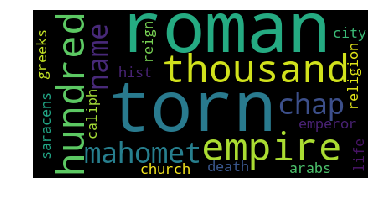

《 THE HISTORIES CAIUS COBNELIUS TACITUS 》:
 note,quam,have,quod,vitellius,tacitus,subj,galba,inter,neque,otho,quae,apud,essay,word,hist,sense,militum,exercitus,ejus


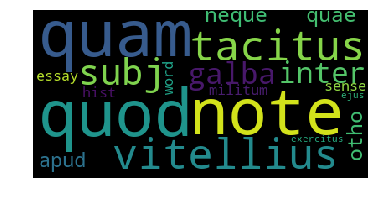

《 THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV 》:
 upon,jews,city,very,josephus,while,temple,time,king,place,wall,titus,come,vespasian,jerusalem,country,together,away,army,because


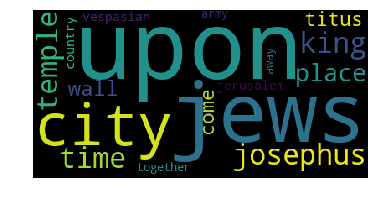

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL, I 》:
 roman,empire,emperor,rome,hist,senate,death,decline,fall,public,well,time,power,life,general,august,ancient,army,reign,long


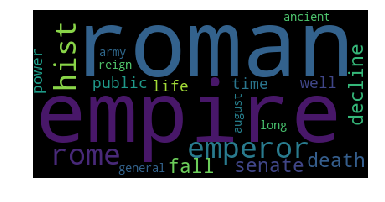

《 THE HISTORY OF TACITUS. BOOK I. VOL. V 》:
 book,otho,vitellius,history,time,tacitus,galba,army,section,rome,nero,legion,emperor,public,city,whole,vespasian,enemy,camp,prince


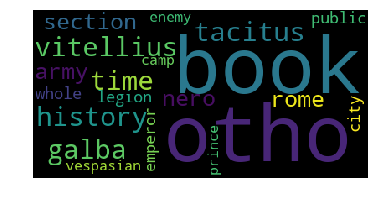

《 THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY 》:
 gold,silver,kind,time,found,account,copper,lead,weight,order,while,substance,word,upon,name,note,minium,part,term,book


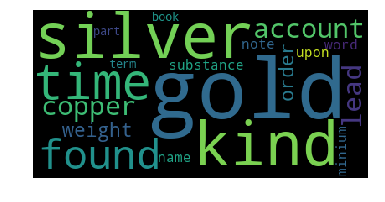

《 THE HISTORY OF THE ROMAN EMPIRE. VOL. V 》:
 roman,chap,empire,justinian,thousand,emperor,hundred,fall,decline,belisarius,rome,italy,king,name,death,romans,city,reign,general,public


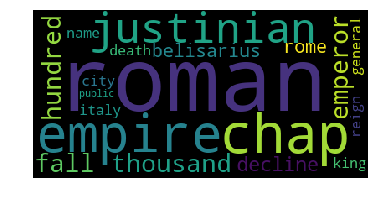

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II 》:
 julian,roman,empire,chap,emperor,decline,fall,public,death,constantine,constantius,troops,theodosius,army,city,general,east,military,reign,imperial


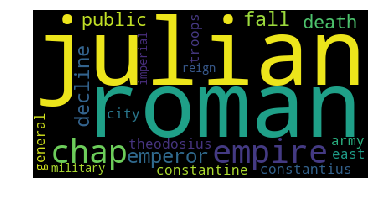

《 THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II 》:
 upon,peloponnesian,have,time,whole,enemy,though,present,fleet,farther,therefore,city,hundred,state,sicily,make,land,force,athenian,army


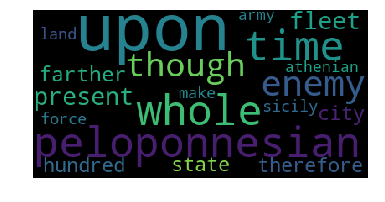

《 TITUS LIVIUS' ROMAN 》:
 have,roman,chap,city,time,upon,rome,enemy,senate,consuls,army,titus,history,consul,book,camp,country,livius,volsci,year


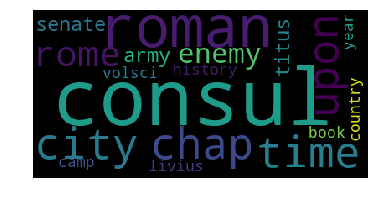

《 THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL, I 》:
 city,time,fuch,enemy,rome,fhould,againft,fenate,thefe,confuls,thofe,fame,roman,firft,conful,mould,book,camp,patricians,year


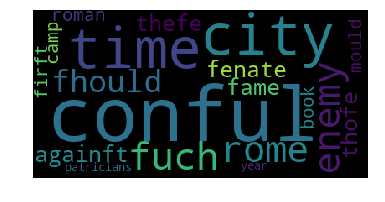

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV 》:
 roman,chap,empire,emperor,fall,decline,justinian,thousand,belisarius,hundred,rome,italy,reign,romans,constantinople,city,death,king,name,palace


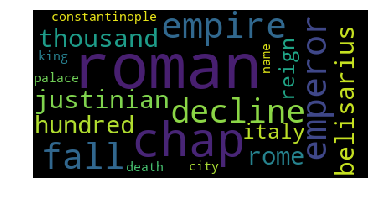

《 DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II 》:
 have,name,town,city,ancient,place,river,time,part,strab,about,roman,coast,temple,ptol,though,first,pliny,country,plin


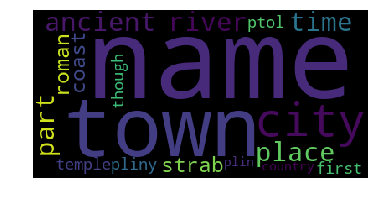

《 THE LEARNED AND AUTHENTIC JEWISH HISTORIAN AND CELEBRATED WARRIOR. VOL. III 》:
 upon,jews,have,king,herod,made,about,sent,city,very,before,time,while,come,because,chap,caesar,agrippa,country,thou


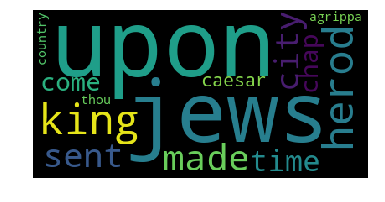

《 LIVY. VOL. III 》:
 have,enemy,rome,consul,time,samnites,roman,army,consuls,camp,senate,book,while,history,city,battle,thousand,sent,livy,dictator


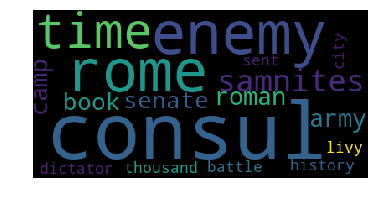

《 LIVY. VOL. V 》:
 time,rome,enemy,city,roman,scipio,king,sent,senate,army,consul,while,book,thousand,history,troops,camp,general,hannibal,livy


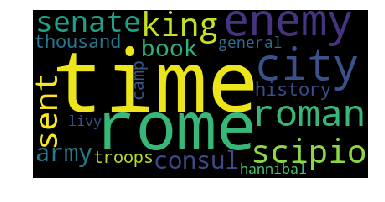

《 THE HISTORICAL ANNALS OF CORNELIUS TACITUS. VOL. I 》:
 tiberius,time,germanicus,senate,rome,augustus,roman,prince,public,army,tacitus,piso,emperor,drusus,general,country,nothing,before,name,father


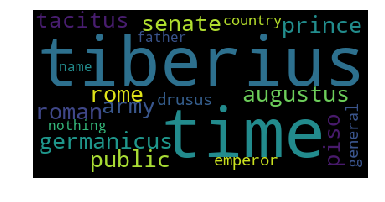

《 THE HISTORY OF THE PELOPONNESIAN WAR. VOL. I 》:
 upon,such,time,before,athens,city,about,hath,very,year,though,over,whole,athenian,public,greece,present,peloponnesian,power,place


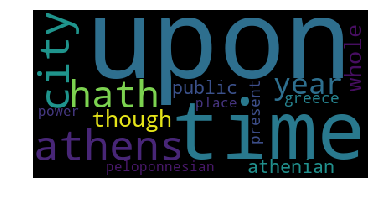

《 THE LEARNED AND AUTHENTIC JEWISH HISTORIAN,  AND CELEBRATED WARRIOR. VOL. IV 》:
 king,jews,have,upon,herod,very,city,sent,temple,chap,time,country,army,come,jerusalem,because,while,book,away,make


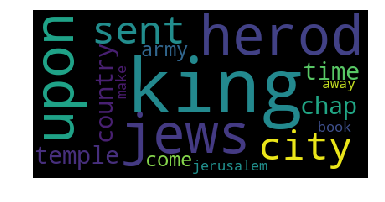

《 THE DESCRIPTION OF GREECE 》:
 city,statue,page,place,temple,apollo,homer,river,jupiter,time,account,daughter,part,olympic,therefore,fame,hence,greece,picture,earth


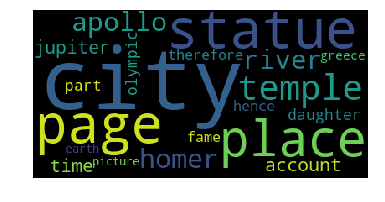

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. III 》:
 torn,roman,hundred,thousand,empire,emperor,justinian,name,rome,city,death,hist,constantinople,mahomet,reign,life,fall,general,italy,public


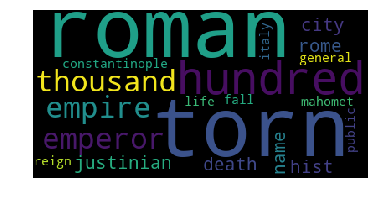

《 THE HISTORY OF ROME. VOL. III 》:
 roman,sulla,rome,senate,time,state,such,army,king,government,italy,very,gracchus,book,general,chap,italian,gaius,consul,like


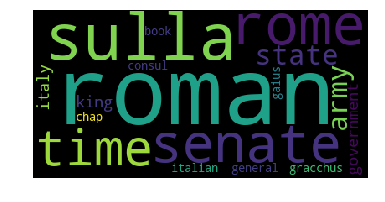

《 THE HISTORY OF TACITUS. BOOK I. VOL. IV 》:
 nero,book,life,time,rome,emperor,death,daughter,tacitus,wife,public,roman,table,augustus,prince,claudius,section,suet,galba,city


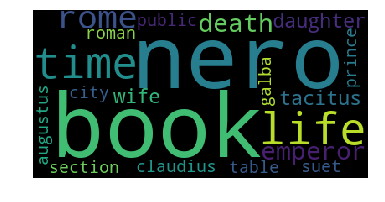

《 THE FLAVIUS JOSEPHU 》:
 king,upon,have,jews,very,about,city,time,before,sent,come,because,josephus,temple,army,david,country,place,thou,while


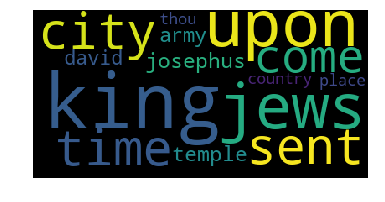

In [10]:
test.highfreq_noun()

#### 2.1.2 输出切分词前每本书的单词数量统计结果

In [11]:
test.print_word_count()

The word counts of each book is:

THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI.txt : 213422
THE HISTORIES CAIUS COBNELIUS TACITUS.txt : 169627
THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV.txt : 233950
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL, I.txt : 272089
THE HISTORY OF TACITUS. BOOK I. VOL. V.txt : 74210
THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY.txt : 30706
THE HISTORY OF THE ROMAN EMPIRE. VOL. V.txt : 205502
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II.txt : 166971
THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II.txt : 136976
TITUS LIVIUS' ROMAN.txt : 175865
THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL, I.txt : 192044
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV.txt : 175260
DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II.txt : 1659053
THE LEARNED AND AUTHENTIC JEWISH HISTORIAN AND CELEBRATED WARRIOR. VOL. III.txt : 230261
LIVY. VOL. III.txt : 115565
LIVY. VOL. V.txt : 148879
THE HISTORICAL

#### 2.1.3 输出切分词后每本书的单词数量统计结果

In [12]:
test.print_word_count_after_tokenization()

The word counts of each book after tokenize is:

THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI.txt : 165396
THE HISTORIES CAIUS COBNELIUS TACITUS.txt : 125392
THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV.txt : 181456
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL, I.txt : 209020
THE HISTORY OF TACITUS. BOOK I. VOL. V.txt : 57048
THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY.txt : 22774
THE HISTORY OF THE ROMAN EMPIRE. VOL. V.txt : 158930
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II.txt : 130940
THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II.txt : 107044
TITUS LIVIUS' ROMAN.txt : 140445
THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL, I.txt : 149124
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV.txt : 138092
DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II.txt : 1149612
THE LEARNED AND AUTHENTIC JEWISH HISTORIAN AND CELEBRATED WARRIOR. VOL. III.txt : 177201
LIVY. VOL. III.txt : 91736
LIVY. VOL. V.txt : 119873


### 3. 使用TF-IDF的聚类

In [94]:
#TF-IDF
test.tf_idf()
tf_idf_matrix = test.tf_idf_matrix
tf_idf_distm = test.dist_matrix(tf_idf_matrix)

Training TF-IDF model...
TF-IDF Done...


#### 3.1 K-means

Start K-Means Clustering...
[1, 4, 2, 1, 4, 1, 1, 1, 3, 0, 0, 1, 1, 2, 0, 0, 4, 3, 2, 3, 1, 0, 4, 2]
   book_id                                              title  cluster
0       01  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...        1
1       02              THE HISTORIES CAIUS COBNELIUS TACITUS        4
2       03     THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV        2
3       04  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...        1
4       05             THE HISTORY OF TACITUS. BOOK I. VOL. V        4
5       06  THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NA...        1
6       07            THE HISTORY OF THE ROMAN EMPIRE. VOL. V        1
7       08  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...        1
8       09      THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II        3
9       10                                TITUS LIVIUS' ROMAN        0
10      11      THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL. I        0
11      12  THE HISTORY OF THE DECLINE AND FALL

/Users/suhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:222: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


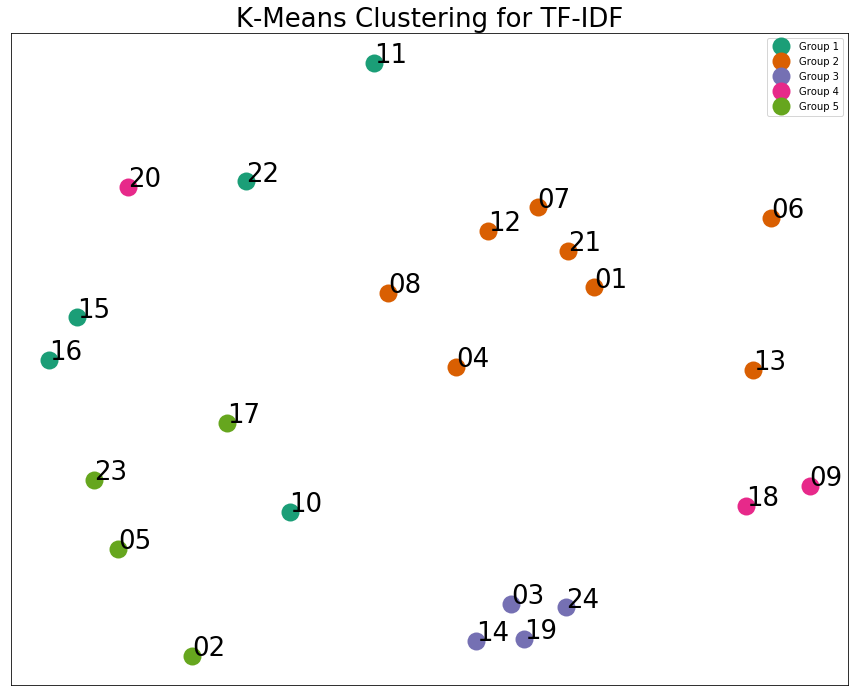

In [108]:
test.k_means_clustering(tf_idf_matrix, tf_idf_distm, 'K-Means Clustering for TF-IDF')

#### 3.2 Hierachical

/Users/suhang/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


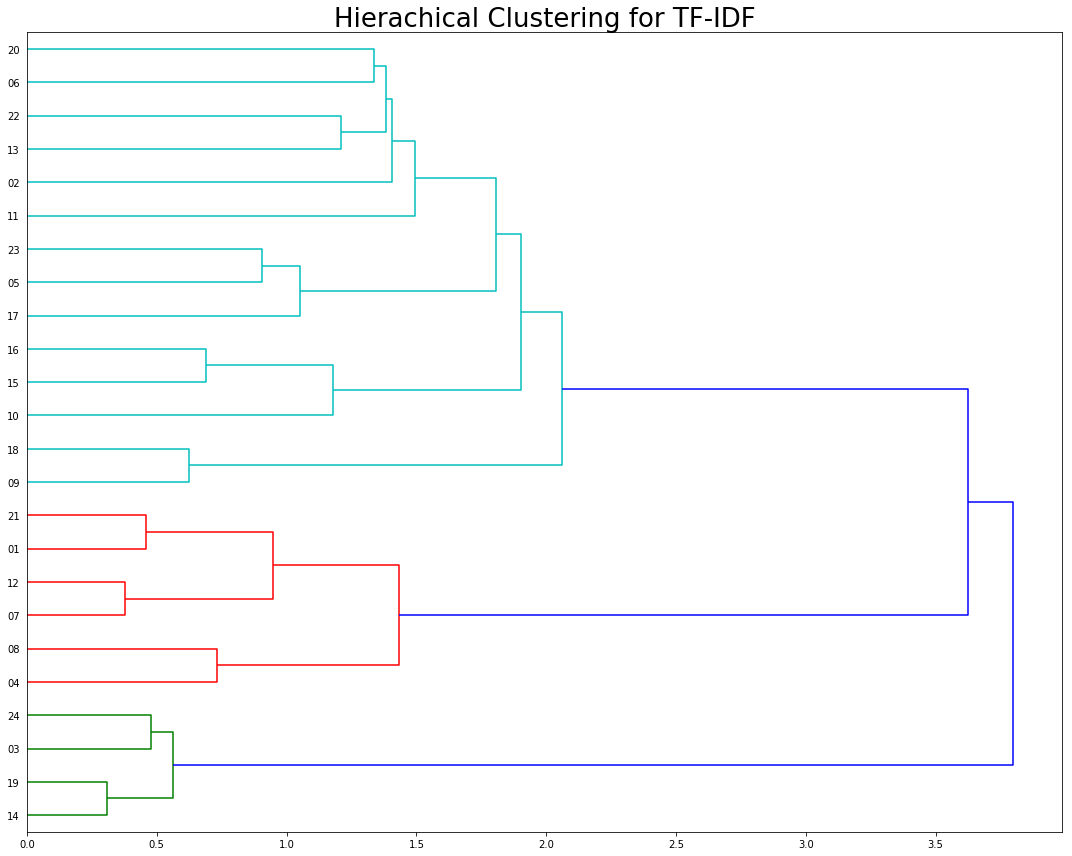

In [117]:
test.hierachical_clustering(tf_idf_distm, 'Hierachical Clustering for TF-IDF')

### 4.使用Doc2vec的聚类

In [48]:
test.doc2vec()
test.doc2vec_to_vectors()
d2v_vector = test.d2v_vector
d2v_distm = test.dist_matrix(d2v_vector)

Start Tagging...
Tagging Done
Training doc2vec model..
Done training..


#### 4.1 k-means

Start K-Means Clustering...
[2, 0, 1, 2, 3, 4, 2, 2, 4, 3, 4, 2, 4, 1, 3, 3, 3, 4, 1, 4, 2, 3, 3, 1]
   book_id                                              title  cluster
0       01  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...        2
1       02              THE HISTORIES CAIUS COBNELIUS TACITUS        0
2       03     THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV        1
3       04  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...        2
4       05             THE HISTORY OF TACITUS. BOOK I. VOL. V        3
5       06  THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NA...        4
6       07            THE HISTORY OF THE ROMAN EMPIRE. VOL. V        2
7       08  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...        2
8       09      THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II        4
9       10                                TITUS LIVIUS' ROMAN        3
10      11      THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL. I        4
11      12  THE HISTORY OF THE DECLINE AND FALL

/Users/suhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:222: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


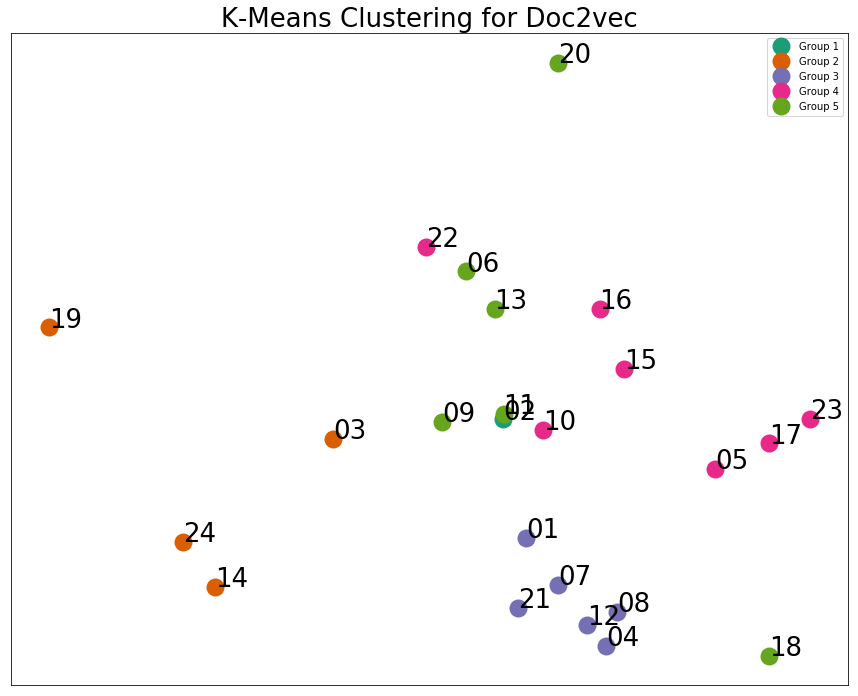

In [111]:
test.k_means_clustering(d2v_vector, d2v_distm, 'K-Means Clustering for Doc2vec')

#### 4.2 Hierachical 

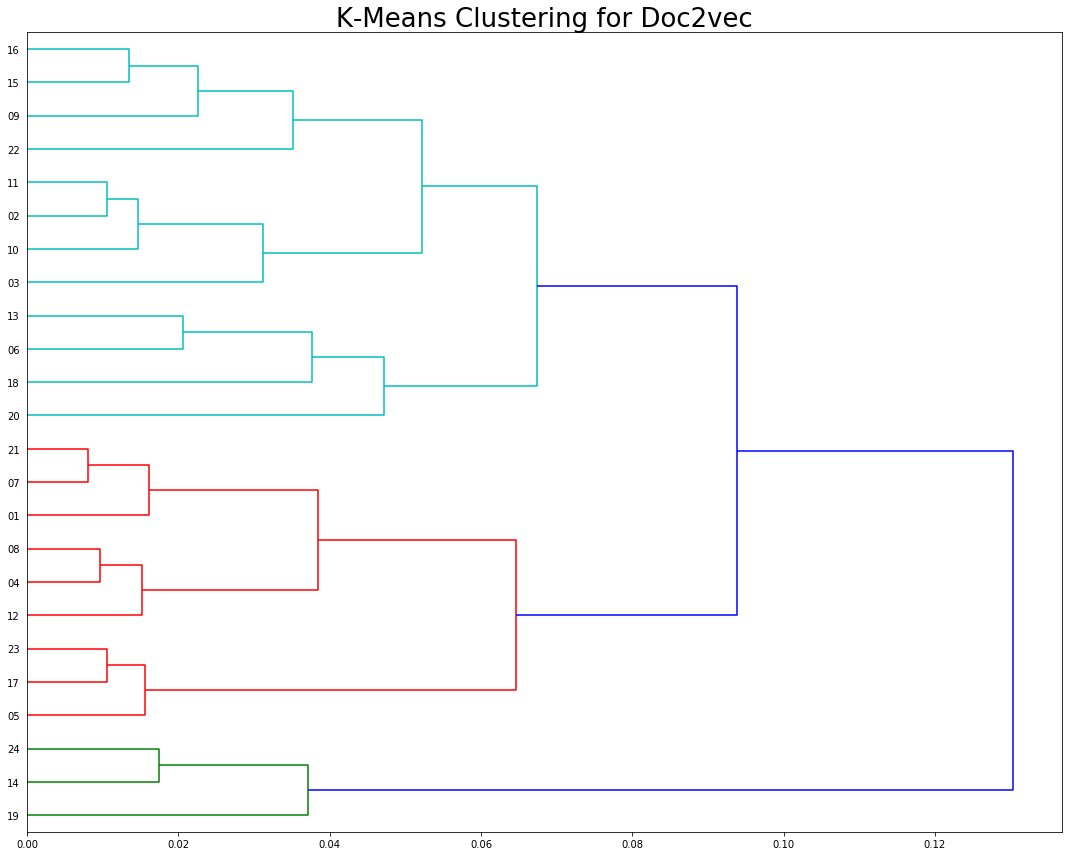

In [118]:
test.hierachical_clustering(d2v_distm, 'K-Means Clustering for Doc2vec')

#### 4.3 Mean-Shift

Mean Shift Training...
Mean Shift Done...
   book_id                                              title  labels
0       01  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...       0
1       02              THE HISTORIES CAIUS COBNELIUS TACITUS       4
2       03     THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV       1
3       04  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...       0
4       05             THE HISTORY OF TACITUS. BOOK I. VOL. V       0
5       06  THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NA...       3
6       07            THE HISTORY OF THE ROMAN EMPIRE. VOL. V       0
7       08  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...       0
8       09      THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II       0
9       10                                TITUS LIVIUS' ROMAN       0
10      11      THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL. I       0
11      12  THE HISTORY OF THE DECLINE AND FALL OF THE ROM...       0
12      13      DICTIONARY GREEK AND ROMAN GEOGR

/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/cluster/mean_shift_.py:292: UserWarning: Binning data failed with provided bin_size=14.934188, using data points as seeds.
  " using data points as seeds." % bin_size)
/Users/suhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:299: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


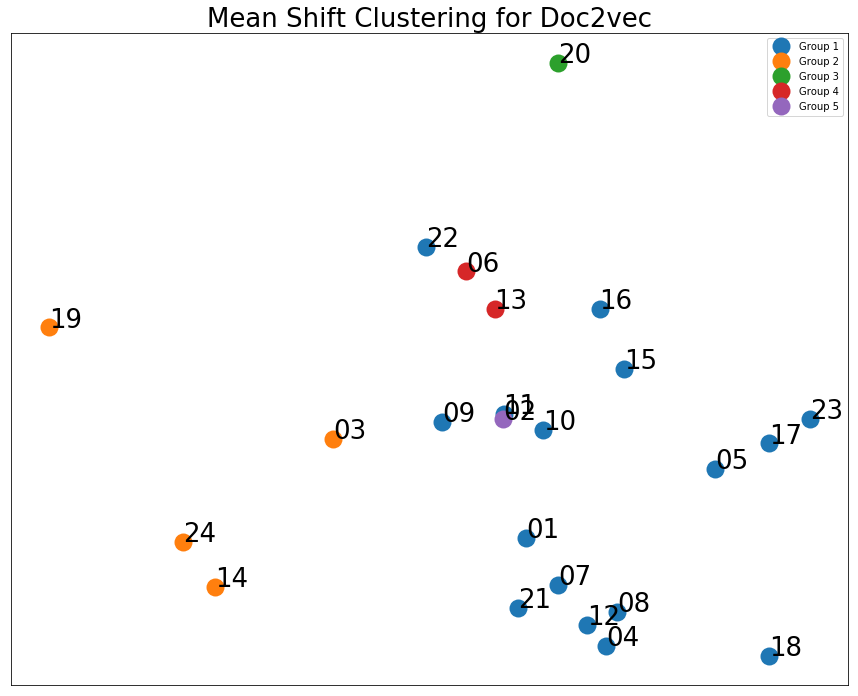

In [113]:
test.mean_shift(d2v_vector, d2v_distm, 'Mean Shift Clustering for Doc2vec')

### 5. LDA

In [122]:
topics = test.LDA()

TypeError: argument of type 'WordListCorpusReader' is not iterable

In [20]:
for topic in topics:
    print(topic)
    print('\n')

(0, '0.006*"jews" + 0.003*"lib" + 0.003*"herod" + 0.002*"josephus" + 0.002*"decline" + 0.002*"jerusalem" + 0.002*"justinian" + 0.002*"antiquities" + 0.002*"hist" + 0.001*"syria"')


(1, '0.009*"cf" + 0.007*"athenians" + 0.003*"peloponnesian" + 0.002*"fuch" + 0.002*"sc" + 0.002*"non" + 0.002*"ch" + 0.002*"fhould" + 0.002*"sed" + 0.002*"againft"')


(2, '0.005*"strab" + 0.004*"pp" + 0.004*"pliny" + 0.004*"plin" + 0.004*"site" + 0.004*"strabo" + 0.004*"situated" + 0.003*"tbe" + 0.003*"ptolemy" + 0.003*"liv"')




### 6. Brief conclusion：

层级聚类的分类结果比5个聚类的k-means结果要好。

在层级聚类中：
- 第一类都是关于古希腊古罗马历史文化的书籍
- 第二类全部是罗马帝国兴衰历史的1-6卷
- 第三类均为关于犹太文化历史信息的书籍